Linear regression
==============


Linear regression is a linear approach to modelling relationship between a **dependent variable** (scalar response) and one or more **independent variables** (explanatory variables).

The relationships are modeled using *linear predictor functions* (linear combination of a set of coefficients and explanatory variables). Their parameters (coefficients) are estimated from the data. For example, with one explanatory variable $x$ and a scalar response $x$, the linear regression is expressed as:

$$y = \beta_0 + \beta_1 \cdot x$$

where *betas* are the coefficients.


More generally, the *model* is a function that performs a matrix multiplication of the input $X$ and the weights $\mathbf{\beta}$ (coefficients) and adds the bias $\epsilon$.

$$y_i = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip} + \varepsilon_i = \mathbf{x_i}^T\mathbf{\beta} + \varepsilon_i,\: i=1,\dots,n$$

in matrix notation:

$$\mathbf{y} = X\mathbf{\beta} + \mathbf{\varepsilon}$$

where: 

* $\mathbf{y}$ is a vector of observed values of the measured variable (dependent variable),
$$\mathbf{y} = \left(\begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_n \end{array}\right)$$

* $\mathbf{X}$ is a matrix of row-vectors $\mathbf{x}_i$, that is observed values of random variables (independent variables) for each corresponding regressand value $y_i$
$$\mathbf{X} = \left(\begin{array}{c} \mathbf{x}_1^T \\ \mathbf{x}_2^T \\ \vdots \\ \mathbf{x}_n^T \end{array}\right)=\left(\begin{array}{cccc} 1 & x_{11} & \dots & x_{1p} \\ 1 & x_{21} & \dots & x_{2p} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_{n1} & \dots & x_{np} \end{array}\right)$$

* $\mathbf{\beta}$ is a $(p+1)$-dimensional *parameter vector*, i.e. a vector of coefficients, where $\beta_0$ is usually called the *intercept term* - multiplied by $x_{i0} = 1$; intercept term is not obligatory - without it (i.e., with no $1$ in the row-vector $\mathbf{x}_i$), the parameter vector has $p$ parameters,
$$\mathbf{\beta} = \left(\begin{array}{c} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_p \end{array}\right)$$

* $\mathbf{\varepsilon}$ is a vector called the *error term* or *noise*, which captures all factors influencing the dependent variable $y$ other than the regressors $\mathbf{x}$
$$\mathbf{\varepsilon} = \left(\begin{array}{c} \varepsilon_0 \\ \varepsilon_1 \\ \vdots \\ \varepsilon_n \end{array}\right)$$

Linear regression focuses on the conditional probability distribution of the response given the values of the predictors.

## Loss function


The loss is the error between the predicted value $\hat{y}$ and the ground-truth $y$. The loss can be calculated using various functions, depending on the estimation methods. One of the most common estimation technique is least-squares estimation.

This method utilizes Mean Squared Error (MSE), which is an average squared error (difference between predicted value and ground-truth), averaged for every example:

$$MSE = \frac{1}{n} \sum_{i=0}^n \left(y_i - \hat{y}_i\right)^2$$
$$\hat{y}_i=\mathbf{\beta}\times\mathbf{x_i}$$

The loss is used by the Gradient Descent algorithm. It optimizes the values of coefficients to find the minimum value of the loss function.

$$\mathbf{\hat{\beta}} = \arg_\hat{\beta}\min MSE$$

![image](https://miro.medium.com/max/2400/1*N5WjbzwsCFse-KPjBWZZ6g.jpeg)

How it works? Using the value of the gradient (i.e. the steepness of the slope), the algorithm applies changes to the weights, to make steps of appropriate size towards the optimum.

If a gradient element is **positive** the loss function can be decreased by **decreasing** the element's value. On the other hand, with **negative** gradient the loss will be decreased by **increasing** the element's value slightly. The increase and decrease of values is proportional to the steepness (value of the gradient) and the **learning rate** $\alpha$.

![image](https://i.imgur.com/2H4INoV.png)
![image](https://i.imgur.com/h7E2uAv.png)

The Gradient Descent algorithm includes the following steps:

  1. Generate predictions
  2. Calculate the loss
  3. Compute gradients w.r.t the weights and biases
  4. Adjust the weights by subtracting values proportional to the gradient
  5. Reset the gradients to zero


### Data

In [3]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import trange


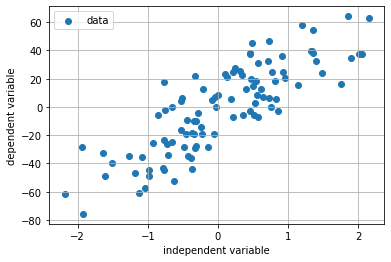

In [4]:
from sklearn.datasets import make_regression

# create a toy dataset
X, y = make_regression(n_samples=100,
                       n_features=1,
                       noise=20,
                       random_state=13)
y = y[:, np.newaxis]  # column vector

def plot(X, y, model=None, loss=None):
    with torch.no_grad():
        fig, ax = plt.subplots()
        ax.set_xlabel("independent variable")
        ax.set_ylabel("dependent variable")
        ax.scatter(X, y, label="data")
        if model is not None:
            inputs = torch.from_numpy(X.astype(np.float32))
            targets = torch.from_numpy(y.astype(np.float32))
            preds = model(inputs)
            ax.plot(X, preds.numpy(), label="predictions")
            if loss is not None:
                print(f"Loss: {loss(preds, targets)}")
        plt.grid()
        plt.legend()
        plt.show()

plot(X, y)


In [5]:
# convert data to torch.Tensor - numpy uses double as default, whereas for PyTorch float32 is default
inputs = torch.from_numpy(X.astype(np.float32))
targets = torch.from_numpy(y.astype(np.float32))


### Linear regression from scratch


1. Create weights `w` == $\mathbf{\beta}$ and biases `b` == $\mathbf{\varepsilon}$ tensors of appropriate shape and random values for linear regression (according to the dimensions of input data). Do not use intercept term.


In [6]:
w = torch.randn(1, inputs.size()[-1], requires_grad=True)
b = torch.randn(targets.size()[-1], requires_grad=True)
print(w)
print(b)


tensor([[-0.2270]], requires_grad=True)
tensor([0.5524], requires_grad=True)


In [7]:
def test_weights_and_biases(weights, biases, data, target):
    x_weights, y_weights = weights.size()
    assert x_weights == target.size()[-1]
    assert y_weights == data.size()[-1]
    assert biases.size() == target.size()[-1:]

test_weights_and_biases(w, b, inputs, targets)
    

2. Prepare model function, which will perform operation:
$$\mathbf{y} = \mathbf{X} \times \mathbf{\beta}^T + \mathbf{\varepsilon}$$

In [8]:
def model(x, w=w, b=b):
    return x @ w.t() + b


In [9]:
def test_model_fn():
    x = torch.tensor([[1, 2], [2, 3], [3, 4]])
    w = torch.tensor([[5, 6]])
    b = torch.tensor([[1], [2], [-1]])
    assert (model(x, w=w, b=b) == torch.tensor([[18], [30], [38]])).all()
    
test_model_fn()

3. Generate model predictions for inputs and plot using matplotlib.


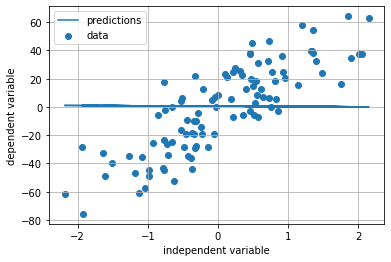

In [10]:
plot(X, y, model)


### Learning


1. Define MSE loss.


In [11]:
def mse(pred, true):
    diff = pred - true
    return torch.sum(diff * diff) / diff.numel()


In [12]:
def test_mse():
    preds = torch.tensor([1, 2, 4])
    trues = torch.tensor([3, 3, 3])
    assert mse(preds, trues) == torch.tensor(2.)

test_mse()

2. Calculate and display loss for model predictions.


In [13]:
loss = mse(model(inputs), targets)
print(loss)


tensor(968.4285, grad_fn=<DivBackward0>)


3. Compute the gradients


In [14]:
loss.backward()


4. Subtract gradients multiplied by learning rate $\alpha=1\cdot10^{-3}$ from weights and biases and zero the gradients.


In [15]:
lr = 1e-3

with torch.no_grad():
    w -= w.grad * lr
    b -= b.grad * lr
    w.grad.zero_()
    b.grad.zero_()


Loss: 966.0640869140625


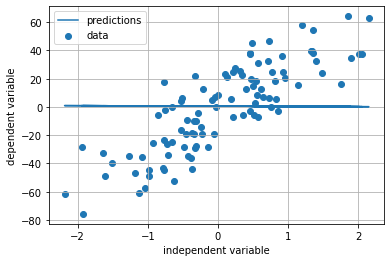

In [16]:
# Plot prediction with loss value
plot(X, y, model, mse)


5. Use the above steps to train the model for 100 epochs


In [17]:
num_epochs = 100
pbar = trange(num_epochs, desc="Training", leave=True)
for epoch in pbar:
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * lr
        b -= b.grad * lr
        w.grad.zero_()
        b.grad.zero_()
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    pbar.refresh()


Loss: 766.5923461914062


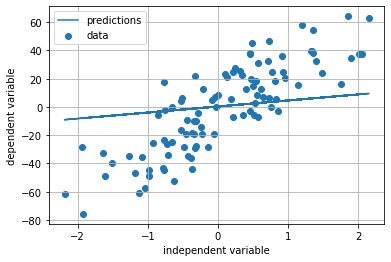

In [18]:
# calculate new loss and plot predictions
plot(X, y, model, mse)
    
# further training or modifying learning rate will enhance the model


### Linear regression using PyTorch built-ins


In [19]:
import torch.nn as nn


In [20]:
# hyper-params
input_size = inputs.size()[-1]
output_size = targets.size()[-1]
num_epochs = 100
lr = 1e-3


In [21]:
# define linear regression model
model = nn.Linear(input_size, output_size)
print(model.weight)
print(model.bias)


Parameter containing:
tensor([[0.7415]], requires_grad=True)
Parameter containing:
tensor([0.9476], requires_grad=True)


In [22]:
# define criterion (loss function) and SGD optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [23]:
pbar = trange(num_epochs, desc="Training", leave=True)
for epoch in pbar:
    preds = model(inputs)
    loss = criterion(preds, targets)
    
    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    pbar.refresh()
    

Loss: 736.6776733398438


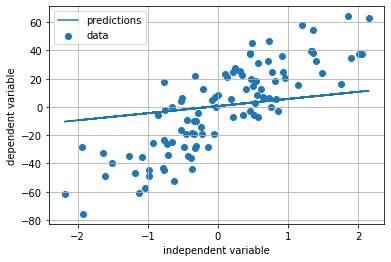

In [24]:
# calculate new loss and plot predictions
plot(X, y, model, mse)


Exercises
-----------


1. Modify the params of the `make_regression` function to have more than one independent value. Train the model on new data.

In [29]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from sklearn.datasets import make_regression

def model(x, w, b):
    #print(x)
    return x @ w.t() + b

# create a toy dataset
X, y = make_regression(n_samples=100,
                       n_features=2,
                       noise=20,
                       random_state=13) # Generate a random regression problem.
y = y[:, np.newaxis]  # column vector
#print(X)

inputs = torch.from_numpy(X.astype(np.float32))
targets = torch.from_numpy(y.astype(np.float32))

w = torch.randn(1, inputs.size()[-1], requires_grad=True)
b = torch.randn(targets.size()[-1], requires_grad=True)
print(w)
print(b)
test_weights_and_biases(w, b, inputs, targets)
lr = 1e-3

num_epochs = 1000
pbar = trange(num_epochs, desc="Training", leave=True)
for epoch in pbar:
    preds = model(inputs,w,b)
    loss = mse(preds, targets)
    loss.backward()
    w.data -= w.grad.detach() * lr
    b.data -= b.grad.detach() * lr
    w.grad.zero_()
    b.grad.zero_()
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    pbar.refresh()
#plot(X, y, model, mse) # Użyć matplotliba z countourF

tensor([[0.1313, 0.0304]], requires_grad=True)
tensor([0.1949], requires_grad=True)


2. Use `sklearn.datasets.load_boston` to load boston house-prices dataset for regression and train linear regression model. Tune the hyperparams to achieve a good result.


In [33]:
import torch.nn as nn
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
print(X)
#hyper-params
input_size = inputs.size()[-1]
output_size = targets.size()[-1]
num_epochs = 10
lr = 1e-3
model = nn.Linear(input_size, output_size)
print(model.weight)
print(model.bias)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
pbar = trange(num_epochs, desc="Training", leave=True)
losses = []
for epoch in pbar:
    preds = model(inputs)
    loss = criterion(preds, targets)
    losses.append(loss)
    # backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    pbar.refresh()
# calculate new loss and plot predictions
print(X.shape)
print(y.shape)
plt(losses)
#plot(X, y, model, mse)
    

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]]
Parameter containing:
tensor([[0.1276, 0.1119]], requires_grad=True)
Parameter containing:
tensor([0.1173], requires_grad=True)



(506, 13)
(506,)


TypeError: plot() missing 1 required positional argument: 'y'

3. Prepare training function that will train the model and plot how the MSE changes through epochs.


In [34]:
def train(model, inputs, outputs, num_epochs, lr):
    loss_values = []
    for epoch in pbar:
        preds = model(inputs)
        loss = criterion(preds, targets)
        loss_values.append(loss)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        pbar.refresh()
    #print(loss_values)
    plt.plot(loss_values)
    


Parameter containing:
tensor([[0.0693, 0.2111]], requires_grad=True)
Parameter containing:
tensor([0.3755], requires_grad=True)


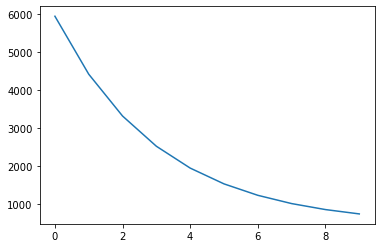

In [36]:
import torch.nn as nn
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=100,
                       n_features=1,
                       noise=20,
                       random_state=13)
#print(X)
#hyper-params
input_size = inputs.size()[-1]
output_size = targets.size()[-1]
num_epochs = 10
lr = 1e-1
model = nn.Linear(input_size, output_size)
print(model.weight)
print(model.bias)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
pbar = trange(num_epochs, desc="Training", leave=True)
train(model,inputs,targets,num_epochs,lr)
# calculate new loss and plot predictions
#plot(X, y, model, mse)